In [42]:
import os 
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_regression, SelectFromModel, mutual_info_regression
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import BinaryEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
os.chdir('..')

In [4]:
df = pd.read_csv('ENG_DATA/CLEANED/12-8_Cleaned_df.csv', index_col = [0])

# Fix Missing Data

In [5]:
#fix a bug 
for l in ['charter', 'private', 'public', 'gsRating', 'enrollment']: 
    df[l].fillna(df[l].median(), inplace=True)

# Add Dates

In [6]:
df["on_market_date"] = df["on_market_date"].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
df["sale_date"] = df["sale_date"].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))

In [7]:
df["on_market_month_year"] = df["on_market_date"].apply(lambda x: x.strftime("%m/%Y"))
df["sale_month_year"] = df["sale_date"].apply(lambda x: x.strftime("%m/%Y"))

# Functions to Test

In [44]:
rf = RandomForestRegressor(random_state=0, n_estimators = 20, n_jobs = -1)
lr = LinearRegression()
std_scaler = StandardScaler()

In [43]:
def get_score(model, x, y):
    # Split dataset into train and validation subsets:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    return score
def get_feature_importance(model, x, y): 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    return pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
def get_coef(model, x, y): 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    return pd.DataFrame(model.coef_, index = X_train.columns, columns=['coef']).sort_values('coef',ascending=False)

In [15]:
x = df.drop(columns = ['sale_price', 'orig_list_price', 'city', 'full_address', 'park_leased'])
y = df.sale_price
cols_num = list(x.select_dtypes(include = 'number').columns)
cols_cat = list(x.select_dtypes(exclude = 'number').columns)
x_cat = x.select_dtypes(include = 'number')

# Feature Highlighting & Baseline

In [16]:
x_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23720 entries, 0 to 23719
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   longitude                    23720 non-null  float64
 1   latitude                     23720 non-null  float64
 2   elevation                    23720 non-null  float64
 3   zip                          23720 non-null  int64  
 4   area                         23720 non-null  int64  
 5   district_no                  23720 non-null  int64  
 6   subdist_no                   23720 non-null  int64  
 7   cdom                         23720 non-null  int64  
 8   rooms                        23720 non-null  int64  
 9   baths                        23720 non-null  float64
 10  beds                         23720 non-null  int64  
 11  lot_acres                    23720 non-null  float64
 12  year_built                   23720 non-null  int64  
 13  num_parking     

In [17]:
x_cat.nunique()

longitude         11366
latitude          12762
elevation         15267
zip                  58
area                 86
                  ...  
vandalism            87
vehicle theft        85
warrants             76
weapon laws          49
totalincidents      102
Length: 64, dtype: int64

In [18]:
x_cat.head(5)

,longitude,latitude,elevation,zip,area,district_no,subdist_no,cdom,rooms,baths,...,stolen property,suicide,suspicious occ,trea,trespass,vandalism,vehicle theft,warrants,weapon laws,totalincidents
0,-122.50965,37.780280,200.83,94121,1050,1,1050,4,8,3.5,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,44.0
1,-122.50929,37.762608,23.21,94122,2030,2,2030,36,9,5.0,...,34.0,10.0,444.0,0.0,60.0,680.0,856.0,192.0,65.0,8385.0
2,-122.50924,37.777330,189.11,94121,1050,1,1050,42,5,1.0,...,6.0,1.0,37.0,0.0,3.0,59.0,79.0,9.0,9.0,976.0
3,-122.50919,37.776695,175.89,94121,1050,1,1050,24,8,4.0,...,6.0,1.0,37.0,0.0,3.0,59.0,79.0,9.0,9.0,976.0
4,-122.50919,37.776695,175.89,94121,1050,1,1050,13,8,4.0,...,6.0,1.0,37.0,0.0,3.0,59.0,79.0,9.0,9.0,976.0


In [19]:
%%time
print("r2_score: {:.3f}".format(get_score(rf, x.select_dtypes(include = 'number'), y)))

r2_score: 0.845
CPU times: user 12.8 s, sys: 161 ms, total: 13 s
Wall time: 4.39 s


# Scaling Numerical Columns

In [21]:
x_sc = x.copy()

In [22]:
xy_scaler = std_scaler.fit(x_sc[cols_num])
x_sc[cols_num]=xy_scaler.transform(x_sc[cols_num])

In [23]:
%%time
print("r2_score: {:.3f}".format(get_score(rf, x_sc.select_dtypes(include = 'number'), y)))

r2_score: 0.844
CPU times: user 12.4 s, sys: 120 ms, total: 12.5 s
Wall time: 3.96 s


# Feature Elimination
1. Drop Highly Correlated Features

In [24]:
# FROM: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = x_sc[cols_num].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# to_drop.remove('sale_year')

In [25]:
x_fe = x_sc.drop(x_sc[to_drop], axis=1).copy()
print("RF r2_score: {:.3f}".format(get_score(rf, x_fe.select_dtypes(include = 'number'), y)))

RF r2_score: 0.848


# Feature Transformation 
1. Ordinal Encode - label data

In [26]:
x_rf = x_fe.copy()

In [27]:
x_rf.drop(columns = ['on_market_date', 'sale_date'], inplace=True)

## Ordinal Encoding

In [28]:
ce_oe = OrdinalEncoder(cols = ['on_market_month_year', 'sale_month_year'])
x_rf2 = ce_oe.fit_transform(x_rf, y)

In [29]:
print("RF r2_score: {:.3f}".format(get_score(rf, x_rf2.select_dtypes(include = 'number'), y)))

RF r2_score: 0.851


# Just Drop 2 Columns from Scaler and use (best)

In [30]:
x_fe.drop(columns = ['on_market_month_year', 'sale_month_year'], inplace=True)

In [31]:
print("RF r2_score: {:.3f}".format(get_score(rf, x_fe.select_dtypes(include = 'number'), y)))

RF r2_score: 0.848


In [32]:
x_fe.columns.shape[0]

51

# Remove 20 Least Important Features

In [33]:
feature_import = get_feature_importance(rf, x_fe.select_dtypes(include = 'number'), y)

In [34]:
x_lip = x_fe.drop(list(feature_import.tail(20)["importance"].index), axis=1)

In [35]:
print("RF r2_score: {:.3f}".format(get_score(rf, x_lip.select_dtypes(include = 'number'), y)))

RF r2_score: 0.841


In [36]:
x_lip.drop(columns = "on_market_date", inplace=True)

# Add 1-Hot Encoded of Most Important Views

In [49]:
x_1ht = x_lip.merge(x_lip['views'].str.get_dummies(sep=',').rename(lambda x: 'views_' + x, axis='columns'), left_index=True, right_index=True).copy()

In [51]:
coef_df = get_coef(lr, x_1ht.select_dtypes(include = 'number'), y)

In [125]:
coef_df

,coef
views_MRNA,1.803099e+06
views_GGTE,5.609996e+05
latitude,4.678384e+05
views_MTPS,4.536931e+05
baths,4.517947e+05
on_market_year,3.080468e+05
area,2.652080e+05
views_BAY,2.162634e+05
views_LAKE,1.707036e+05
views_GRDN,1.431519e+05


In [111]:
good_views = list(coef_df[coef_df.index.str.startswith('views', na=False)].query('coef > 4e5').index)
bad_views = list(coef_df[coef_df.index.str.startswith('views', na=False)].query('coef < -1e5').index)

In [122]:
x_1htt = x_1ht.copy()

In [123]:
x_1htt["n_bad_views"] = x_1htt[bad_views].sum(axis=1)
x_1htt["n_good_views"] = x_1htt[good_views].sum(axis=1)
x_1htt.drop(good_views + bad_views, axis=1, inplace=True)

In [124]:
print("RF r2_score: {:.3f}".format(get_score(rf, x_1htt.select_dtypes(include = 'number'), y)))

RF r2_score: 0.839


In [116]:
x_1htt.query('n_bad_views > 0').shape[0]

1508

In [117]:
x_1htt.query('n_good_views > 0').shape[0]

1046

# Recursive Feature Elimination

In [37]:
# classifications
rfecv = RFECV(rf, step=3, min_features_to_select = 10,
              scoring='r2')
rfecv.fit(x_lip.select_dtypes(include = 'number'), y)
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 30


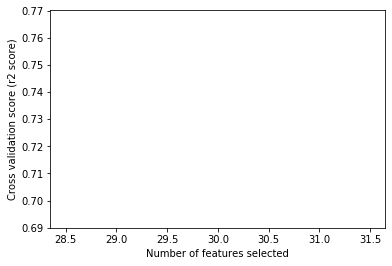

In [90]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2 score)")
plt.plot(range(30, 3*len(rfecv.grid_scores_) + 30, 3), rfecv.grid_scores_)
plt.show()

# Export

In [86]:
def export_df(df_, name_):
    month_day = datetime.now().strftime('%m-%d')
    df_.to_csv('ENG_DATA/SELECTED/{}_{}_train.csv'.format(month_day, name_))

In [113]:
df_out = x_lip.merge(y, left_index = True, right_index = True)

In [114]:
export_df(df_out, "rf_all")

# Remove Location Data

In [81]:
x_lip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23720 entries, 0 to 23719
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   longitude          23720 non-null  float64       
 1   latitude           23720 non-null  float64       
 2   elevation          23720 non-null  float64       
 3   street_name        23720 non-null  object        
 4   zip                23720 non-null  float64       
 5   area               23720 non-null  float64       
 6   cdom               23720 non-null  float64       
 7   sale_date          23720 non-null  datetime64[ns]
 8   rooms              23720 non-null  float64       
 9   baths              23720 non-null  float64       
 10  beds               23720 non-null  float64       
 11  lot_acres          23720 non-null  float64       
 12  year_built         23720 non-null  float64       
 13  zoning             23720 non-null  object        
 14  drive_

In [126]:
location_cols = ['longitude', 'latitude', 'elevation', 'street_name', 'zip', 'area', 'street_name', 'zoning', 'neighborhood', 'views']

In [127]:
x_noloc = x_lip.drop(location_cols, axis=1)

In [128]:
print("RF r2_score: {:.3f}".format(get_score(rf, x_noloc.select_dtypes(include = 'number'), y)))

RF r2_score: 0.788


In [129]:
export_df(x_noloc.merge(y, left_index = True, right_index = True), "rf_noloc")